In [1]:
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.ndimage as nd
from tqdm.notebook import tqdm
import os, sys
%matplotlib inline

### Data loading

In [2]:
images = []
masks = []
with open('../data/cell_data_3A.pkl', 'rb') as f:
    for item in pkl.load(f):
        if not item:
            continue

        if any([n in item['name'] for n in ['103', '020', '018']]):
            continue

        images.append(item['image'][:-140])
        masks.append(item['mask'][:-140])

indexes = np.arange(len(images))

train, test = train_test_split(indexes, test_size=0.1, random_state=42)
#train, val = train_test_split(train, test_size=0.1, random_state=42)

train_images = np.array([images[item] / 255 for item in train])
train_masks = np.array([masks[item] for item in train])

test_images = np.array([images[item] / 255 for item in test])
test_masks = np.array([masks[item] for item in test])


In [3]:
def iou_score(result1, result2):
    intersection = np.logical_and(result1, result2)
    union = np.logical_or(result1, result2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


### Check if testing images are correct

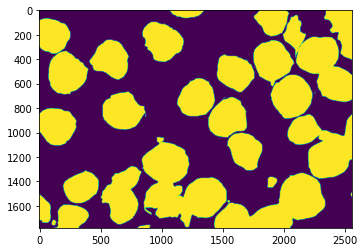

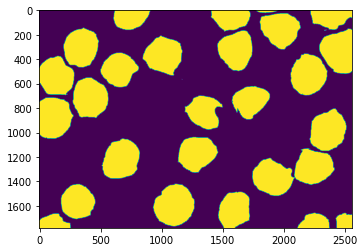

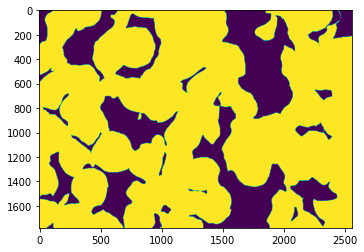

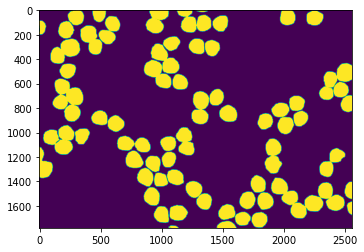

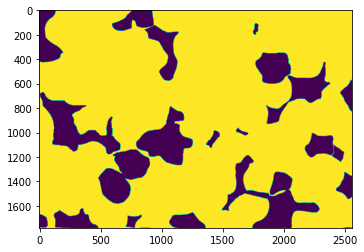

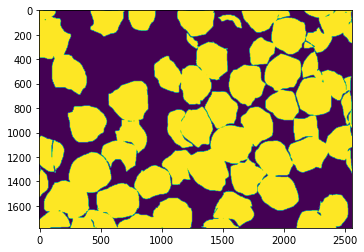

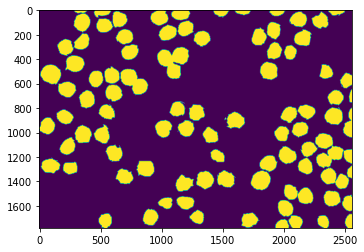

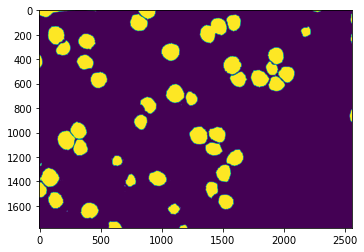

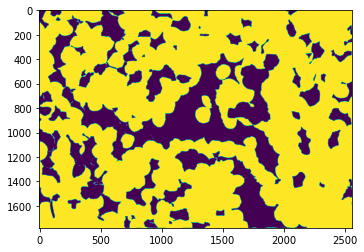

In [4]:
for test_mask in test_masks:
    plt.imshow(test_mask[:, :, 0])
    plt.show()

# Thresholdings

## Global thresholding (v=127)

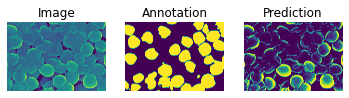

IOU: 0.262858339447829, ret: 127.0 



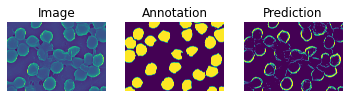

IOU: 0.18586119065137618, ret: 127.0 



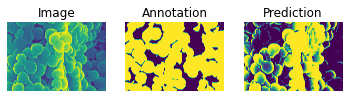

IOU: 0.4467315694033382, ret: 127.0 



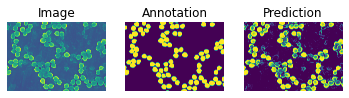

IOU: 0.748895745371874, ret: 127.0 



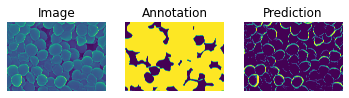

IOU: 0.10192395321619103, ret: 127.0 



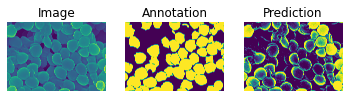

IOU: 0.39615537625454045, ret: 127.0 



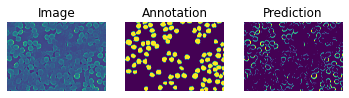

IOU: 0.19164557352383843, ret: 127.0 



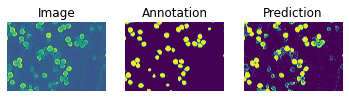

IOU: 0.6998211629667077, ret: 127.0 



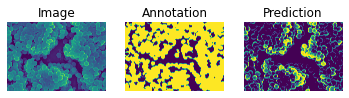

IOU: 0.2372212978176585, ret: 127.0 

 IOU = 0.363457134294817 



In [5]:
iou_scores = []
for img, valid in zip(test_images, test_masks):
    img = img*255
    img = img.astype('uint8')
    ret, thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    fig, ax = plt.subplots(1, 3)
    
    ax[0].set_title('Image')
    ax[0].imshow(img)
    ax[0].axis('off')
    
    ax[1].set_title('Annotation')
    ax[1].imshow(valid[:, :, 0])
    ax[1].axis('off')
    
    ax[2].set_title('Prediction')
    ax[2].imshow(thresh)
    ax[2].axis('off')
    plt.show()
    
    iou = iou_score(thresh, valid[:, :, 0])
    iou_scores.append(iou)
    
    print(f'IOU: {iou_score(thresh, valid[:, :, 0])}, ret: {ret} \n')
    
print(f' IOU = {np.mean(iou_scores)} \n')
    

## Otsu thresholding

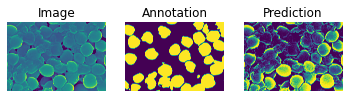

IOU: 0.36006143237410126, ret: 112.0 



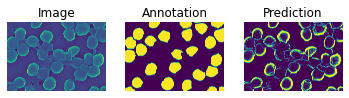

IOU: 0.3160891296456594, ret: 107.0 



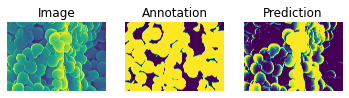

IOU: 0.35699650959042983, ret: 144.0 



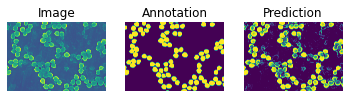

IOU: 0.7530408601620354, ret: 126.0 



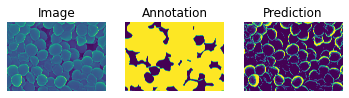

IOU: 0.18540833168636794, ret: 106.0 



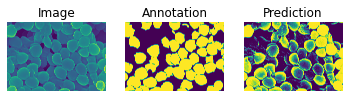

IOU: 0.5323999253522441, ret: 116.0 



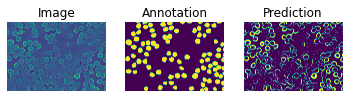

IOU: 0.33677390777033933, ret: 102.0 



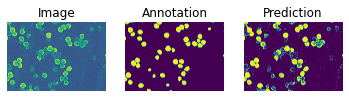

IOU: 0.709897072867559, ret: 132.0 



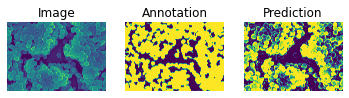

IOU: 0.5534910809084396, ret: 87.0 

 IOU = 0.45601758337301956 



In [7]:
iou_scores = []
for img, valid in zip(test_images, test_masks):
    img = img*255
    img = img.astype('uint8')
    ret, thresh = cv2.threshold(img,127,255,cv2.THRESH_OTSU)
    fig, ax = plt.subplots(1, 3)
    
    ax[0].set_title('Image')
    ax[0].imshow(img)
    ax[0].axis('off')
    
    ax[1].set_title('Annotation')
    ax[1].imshow(valid[:, :, 0])
    ax[1].axis('off')
    
    ax[2].set_title('Prediction')
    ax[2].imshow(thresh)
    ax[2].axis('off')
    plt.show()
    
    iou = iou_score(thresh, valid[:, :, 0])
    iou_scores.append(iou)
    
    print(f'IOU: {iou_score(thresh, valid[:, :, 0])}, ret: {ret} \n')
    
print(f' IOU = {np.mean(iou_scores)} \n')

## Adaptive threshold

In [12]:
def get_thresh(img, algo, bs):
    
    if algo == 'mean':
        adaptiveMethod = cv2.ADAPTIVE_THRESH_MEAN_C
    elif algo == 'gaussian':
        adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
        
    img = img*255
    img = img.astype('uint8')
    thresh = cv2.adaptiveThreshold(img,255, adaptiveMethod=adaptiveMethod, thresholdType=cv2.THRESH_BINARY, blockSize=bs, C=2)
    
    return thresh
    

In [14]:
pos_bs = [101, 301, 501, 801, 1001, 1301, 1501, 1701]
cv_results = {}
for bs in tqdm(pos_bs):
    for algo in ['mean', 'gaussian']:
        iou_scores = []
        for img, valid in zip(train_images, train_masks):
            thresh = get_thresh(img, algo, bs)
            iou = iou_score(thresh, valid[:, :, 0])
            iou_scores.append(iou)
            
        cv_results[(bs, algo)] = np.mean(iou_scores)
        

In [15]:
cv_results

{(101, 'mean'): 0.30913168175415723,
 (101, 'gaussian'): 0.2866540684987227,
 (301, 'mean'): 0.39997825199393083,
 (301, 'gaussian'): 0.3380153900899118,
 (501, 'mean'): 0.4491721646057698,
 (501, 'gaussian'): 0.38121918620043005,
 (801, 'mean'): 0.4758394665216185,
 (801, 'gaussian'): 0.4238627413038669,
 (1001, 'mean'): 0.4832979602579754,
 (1001, 'gaussian'): 0.442677594801432,
 (1301, 'mean'): 0.48956860870281405,
 (1301, 'gaussian'): 0.46086262503032394,
 (1501, 'mean'): 0.4913516055524078,
 (1501, 'gaussian'): 0.46874216933807933,
 (1701, 'mean'): 0.492039450531384,
 (1701, 'gaussian'): 0.474534761958975}

### Adaptive threshold mean, blockSize=1701

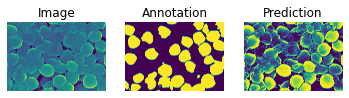

IOU: 0.4203639127640788 



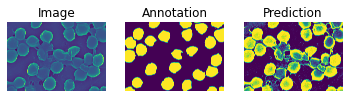

IOU: 0.6421944766494009 



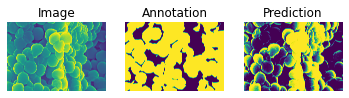

IOU: 0.402526719745231 



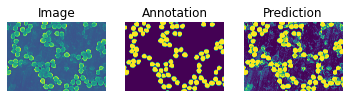

IOU: 0.6720737367181158 



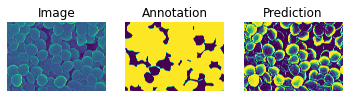

IOU: 0.41736217664617487 



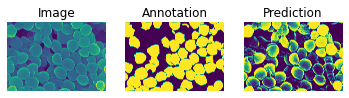

IOU: 0.5038395234385511 



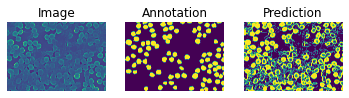

IOU: 0.47068524611718143 



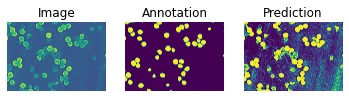

IOU: 0.360803410215725 



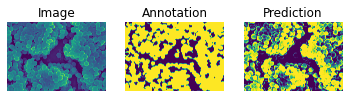

IOU: 0.5702673925751918 

 IOU = 0.49556851054107237 



In [16]:
iou_scores = []
for img, valid in zip(test_images, test_masks):
    img = img*255
    img = img.astype('uint8')
    thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY, blockSize=1701, C=2)
    fig, ax = plt.subplots(1, 3)
    
    ax[0].set_title('Image')
    ax[0].imshow(img)
    ax[0].axis('off')
    
    ax[1].set_title('Annotation')
    ax[1].imshow(valid[:, :, 0])
    ax[1].axis('off')
    
    ax[2].set_title('Prediction')
    ax[2].imshow(thresh)
    ax[2].axis('off')
    plt.show()
    
    iou = iou_score(thresh, valid[:, :, 0])
    iou_scores.append(iou)
    
    print(f'IOU: {iou_score(thresh, valid[:, :, 0])} \n')
    
print(f' IOU = {np.mean(iou_scores)} \n')
    

### Adaptive threshold gaussian, blockSize=1701

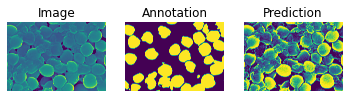

IOU: 0.4247181886540229 



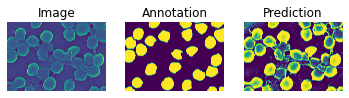

IOU: 0.6136690785111608 



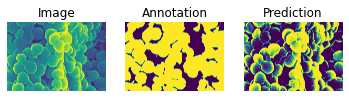

IOU: 0.4310573701211465 



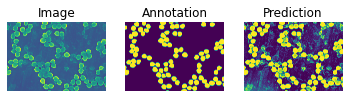

IOU: 0.6515313325103221 



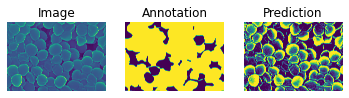

IOU: 0.4350021591402144 



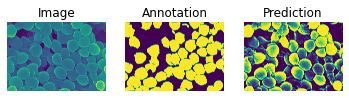

IOU: 0.540972160700601 



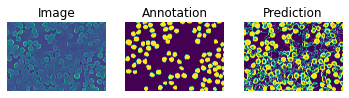

IOU: 0.46664557093746395 



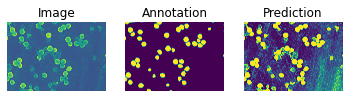

IOU: 0.3444307177408528 



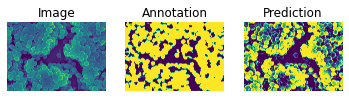

IOU: 0.5494285616106069 

 IOU = 0.49527279332515456 



In [17]:
iou_scores = []
for img, valid in zip(test_images, test_masks):
    img = img*255
    img = img.astype('uint8')
    thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY, blockSize=1701, C=2)
    fig, ax = plt.subplots(1, 3)
    
    ax[0].set_title('Image')
    ax[0].imshow(img)
    ax[0].axis('off')
    
    ax[1].set_title('Annotation')
    ax[1].imshow(valid[:, :, 0])
    ax[1].axis('off')
    
    ax[2].set_title('Prediction')
    ax[2].imshow(thresh)
    ax[2].axis('off')
    plt.show()
    
    iou = iou_score(thresh, valid[:, :, 0])
    iou_scores.append(iou)
    
    print(f'IOU: {iou_score(thresh, valid[:, :, 0])} \n')
    
print(f' IOU = {np.mean(iou_scores)} \n')

### Adaptive threshold mean, blockSize=1701 + Closing

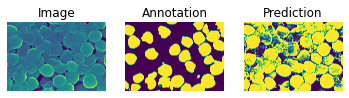

IOU: 0.48727294376739655 



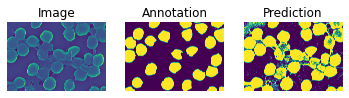

IOU: 0.6495843167025407 



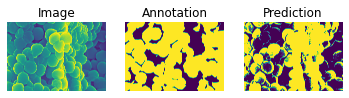

IOU: 0.49203696397458296 



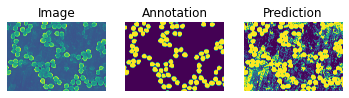

IOU: 0.5096757748914013 



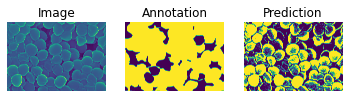

IOU: 0.5399835275366862 



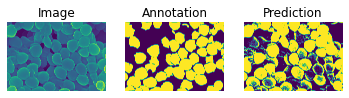

IOU: 0.6207114653849021 



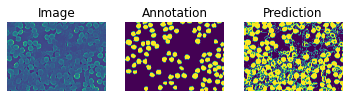

IOU: 0.4664961122626231 



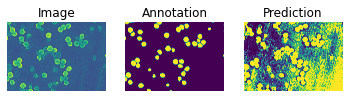

IOU: 0.18769455030796586 



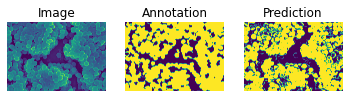

IOU: 0.6542454855162364 

 IOU = 0.5119667933715928 



In [21]:
iou_scores = []
for img, valid in zip(test_images, test_masks):
    img = img*255
    img = img.astype('uint8')
    thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY, blockSize=1701, C=2)
    
    kernel = np.ones((5, 5))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    fig, ax = plt.subplots(1, 3)
    
    ax[0].set_title('Image')
    ax[0].imshow(img)
    ax[0].axis('off')
    
    ax[1].set_title('Annotation')
    ax[1].imshow(valid[:, :, 0])
    ax[1].axis('off')
    
    ax[2].set_title('Prediction')
    ax[2].imshow(thresh)
    ax[2].axis('off')
    plt.show()
    
    iou = iou_score(thresh, valid[:, :, 0])
    iou_scores.append(iou)
    
    print(f'IOU: {iou_score(thresh, valid[:, :, 0])} \n')
    
print(f' IOU = {np.mean(iou_scores)} \n')
    

# Edge-based segmentation

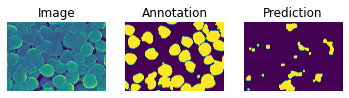

IOU: 0.0426774101920102 



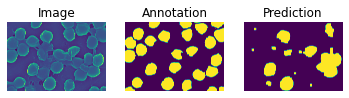

IOU: 0.23737673583457622 



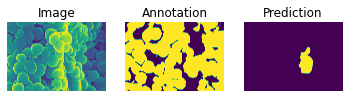

IOU: 0.036117352329986474 



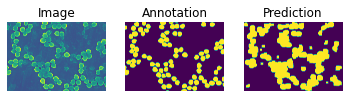

IOU: 0.5394745447979139 



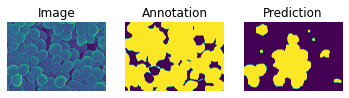

IOU: 0.297191557482991 



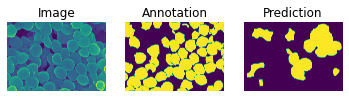

IOU: 0.22711351565735963 



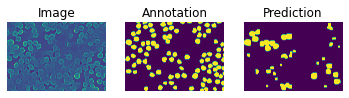

IOU: 0.18694676148821884 



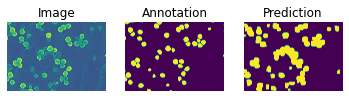

IOU: 0.4859979181965451 



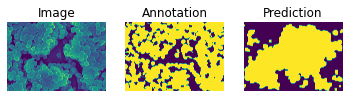

IOU: 0.45768494934490145 

 IOU = 0.27895341614716695 



In [71]:
iou_scores = []
for img, valid in zip(test_images, test_masks):
    
    img = img*255
    img = img.astype('uint8')
    img_blur = cv2.GaussianBlur(img, (5,5), 0)
    edges = cv2.Canny(img_blur, 100, 200)
    edges = cv2.dilate(edges, kernel=np.ones((3, 3), np.uint8), iterations=10)
    fill_im = nd.binary_fill_holes(edges)

    thresh = cv2.morphologyEx(fill_im.astype('uint8'), cv2.MORPH_OPEN, kernel=np.ones((7, 7), np.uint8), iterations=9)

    fig, ax = plt.subplots(1, 3)
    
    ax[0].set_title('Image')
    ax[0].imshow(img)
    ax[0].axis('off')
    
    ax[1].set_title('Annotation')
    ax[1].imshow(valid[:, :, 0])
    ax[1].axis('off')
    
    ax[2].set_title('Prediction')
    ax[2].imshow(thresh)
    ax[2].axis('off')
    plt.show()
    
    iou = iou_score(thresh, valid[:, :, 0])
    iou_scores.append(iou)
    
    print(f'IOU: {iou_score(thresh, valid[:, :, 0])} \n')
    
print(f' IOU = {np.mean(iou_scores)} \n')

# CNN - based segmentation

In [4]:
with open('../data/metrics_dict_list.pkl', 'rb') as f:
    data = pkl.load(f)

In [13]:
iou_scores = []
for i, elem in enumerate(data):
    iou = elem[f'{i}_0']
    iou_scores.append(iou)

In [14]:
np.mean(iou_scores)

0.824795835547977